# Structure Optimization

In [1]:
%matplotlib notebook
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
from potentials import *
from distances import *
from sampling import *

<IPython.core.display.Javascript object>


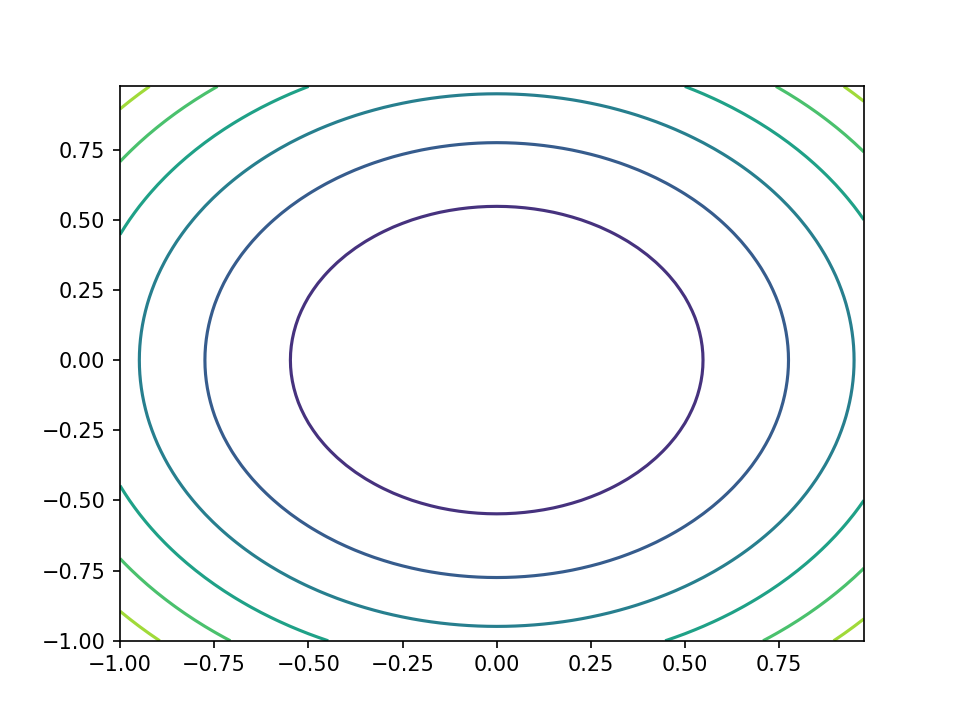

In [3]:
import matplotlib
import matplotlib.cm as cm

delta = 0.025
x = np.arange(-1.0, 1.0, delta)
y = np.arange(-1.0, 1.0, delta)
X, Y = np.meshgrid(x, y)
XY = np.append(X[:, :, None], Y[:, :, None], axis=-1)
Z = potentials.harmonic(XY, [0, 1])

fig, ax = plt.subplots()
ax.contour(X, Y, Z)
#ax.clabel(CS, inline=1, fontsize=10)
#ax.set_title('Simplest default with labels')

In [4]:
def descent( x, a=1e-4, prec=1e-10, maxst=1e6 ):
    """Gradient Descent
    
    Arguments:
        x    (float): position vectors (dim = n x 3)
        a    (float): 'learning rate' alpha = 1e-4
        prec (float): difference between steps, precision = 1e-10
        maxst  (int): max # of steps, maxst = 1e6
    
    Output:
        x: position array,
        step: # of steps needed to converge"""
    
    x = x[None, :, :]
    step = 0
    f = gradients.harmonic( x[-1], [0, 1] )
    x1 = x[-1] - a * f
    
    while(step < maxst and (abs(x[-1] - x1) > prec).all()):
        x = np.append(x, x1[None, :, :], axis=0)
        f = gradients.harmonic( x[-1], [0, 1] )
        x1 = x[-1] - a * f
        step += 1
        
    return x, step

In [5]:
x_init = np.array([[.8, .9], [.2, .3]])
positions, nsteps = descent(x_init, 1e-3)
print('# of steps:', nsteps, '| positions.shape:', positions.shape)
print(positions[-1])

# of steps: 14502 | positions.shape: (14503, 2, 2)
[[3.99760832e-07 4.49730936e-07]
 [9.99402080e-08 1.49910312e-07]]


<IPython.core.display.Javascript object>


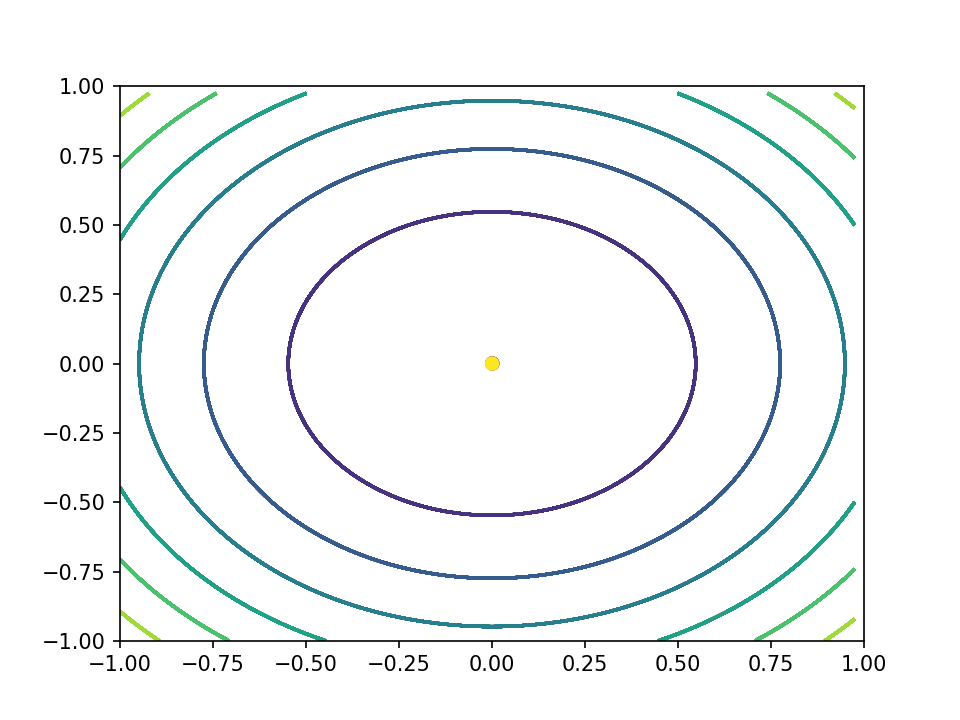

In [6]:
from matplotlib import animation


#import matplotlib.cm as cm
#delta = 0.025
#x = np.arange(-3.0, 3.0, delta)
#y = np.arange(-3.0, 3.0, delta)
#X, Y = np.meshgrid(x, y)
#XY = np.append(X[:, :, None], Y[:, :, None], axis=-1)
#Z = potentials.harmonic(XY, [0, 1])
fig, ax = plt.subplots()
#ax.contour(X, Y, Z)

#fig, ax = plt.subplots(figsize=(8, 8))
colors = np.arange(len(x_init))
scat = ax.scatter(x_init[:,0], x_init[:,1], c=colors)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
def animate(i):
    index = 100*i
    data = positions[index]
    scat.set_offsets(data)
    ax.contour(X, Y, Z)
    return scat

#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=25, bitrate=1800)
anim = animation.FuncAnimation(fig, animate, interval=1)#, frames=750, repeat=False)
#anim.save('LJ_Harmonic_Particles.mp4', writer=writer)

In [149]:
def dist_torch(x): 
    """Calculates distance vectors and distances (euclidian norm of vecs)
    
    Arguments:
        x (float): position vectors (dim = N x 3)
    
    Output:
        dist (float): distances between particle pairs (dim = N x N)
        vecs (float): distance vectors between particle pairs (dim = N x N x 3)
    """
    x = torch.Tensor(x)
    vecs = x[None, :, :] - x[:, None, :]       
    return torch.norm(vecs, dim=-1), vecs

def gradLJ(vecs, sig=1, eps=1):
        dist = dist_torch(vecs)[0].numpy()
        dist[dist!=0] = 1/dist[dist!=0]
        D_att = 6 * sig**6 * dist**8
        D_rep = -12 * sig**12 * dist**14
        D = 4*(eps*(D_att + D_rep))[:, :, None]*vecs
        return np.sum(D, axis=-2)
    
def descent_h_lj( x, a=1e-4, prec=1e-10, maxst=1e6 , k=1/10):
    """Gradient Descent
    
    Arguments:
        x    (float): position vectors (dim = n x 3)
        a    (float): 'learning rate' alpha = 1e-4
        prec (float): difference between steps, precision = 1e-10
        maxst  (int): max # of steps, maxst = 1e6
    
    Output:
        x: position array,
        step: # of steps needed to converge"""
    
    x = x[None, :, :]
    step = 0
    #f = gradients.harmonic(x[-1], [0, 1],k) + gradLJ(x[-1])
    f = gradients.harmonic(x[-1], [0, 1]) + gradients.LJ(vectors(x[-1], boxsize=(0,1)))
    x1 = x[-1] - a * f
    
    while step < maxst and np.linalg.norm(x[-1] - x1) > prec:
        x = np.append(x, x1[None, :, :], axis=0)
        #f = gradients.harmonic(x[-1], [0, 1], k) + gradLJ(x[-1]) 
        f = gradients.harmonic(x[-1], [0, 1]) + gradients.LJ(vectors(x[-1], boxsize=(0,1)))
        x1 = x[-1] - a * f
        step += 1
        
    return x, step

def descent_h_lj_c( x, q, a=1e-4, prec=1e-10, maxst=1e6 , k=1/10):
    """Gradient Descent
    
    Arguments:
        x    (float): position vectors (dim = n x 3)
        a    (float): 'learning rate' alpha = 1e-4
        prec (float): difference between steps, precision = 1e-10
        maxst  (int): max # of steps, maxst = 1e6
    
    Output:
        x: position array,
        step: # of steps needed to converge"""
    
    x = x[None, :, :]
    step = 0
    vecs = vectors(x[-1], boxsize=(0,1))
    #f = gradients.harmonic(x[-1], [0, 1],k) + gradLJ(x[-1])
    f = gradients.harmonic(x[-1], [0, 1]) + gradients.LJ(vecs) - gradients.coulomb(vecs, q)
    x1 = x[-1] - a * f
    
    while step < maxst and np.linalg.norm(x[-1] - x1) > prec:
        x = np.append(x, x1[None, :, :], axis=0)
        vecs = vectors(x[-1], boxsize=(0,1))
        #f = gradients.harmonic(x[-1], [0, 1], k) + gradLJ(x[-1]) 
        f = gradients.harmonic(x[-1], [0, 1]) + gradients.LJ(vecs) - gradients.coulomb(vecs, q)
        x1 = x[-1] - a * f
        step += 1
        
    return x, step

In [77]:
x_init = np.array([[-1., -1e-5], [1., 1e-5]])*2.9
print(np.append(x_init[None, :, :],x_init[None, :, :], axis=0))
positions, nsteps = descent_h_lj(x_init, 1e-3)
print('# of steps:', nsteps, '| positions.shape:', positions.shape)
print(positions[1])
print(positions[-1])

[[[-2.9e+00 -2.9e-05]
  [ 2.9e+00  2.9e-05]]

 [[-2.9e+00 -2.9e-05]
  [ 2.9e+00  2.9e-05]]]
# of steps: 1419 | positions.shape: (1420, 2, 2)
[[-2.89709989e+00 -2.89709989e-05]
 [ 2.89709989e+00  2.89709989e-05]]
[[-5.56753135e-01 -5.56753135e-06]
 [ 5.56753135e-01  5.56753135e-06]]


# of steps: 1419 | positions.shape: (1420, 2, 2)
[[-2.89709989e+00 -2.89709989e-05]
 [ 2.89709989e+00  2.89709989e-05]]
[[-5.56753135e-01 -5.56753135e-06]
 [ 5.56753135e-01  5.56753135e-06]]


<IPython.core.display.Javascript object>


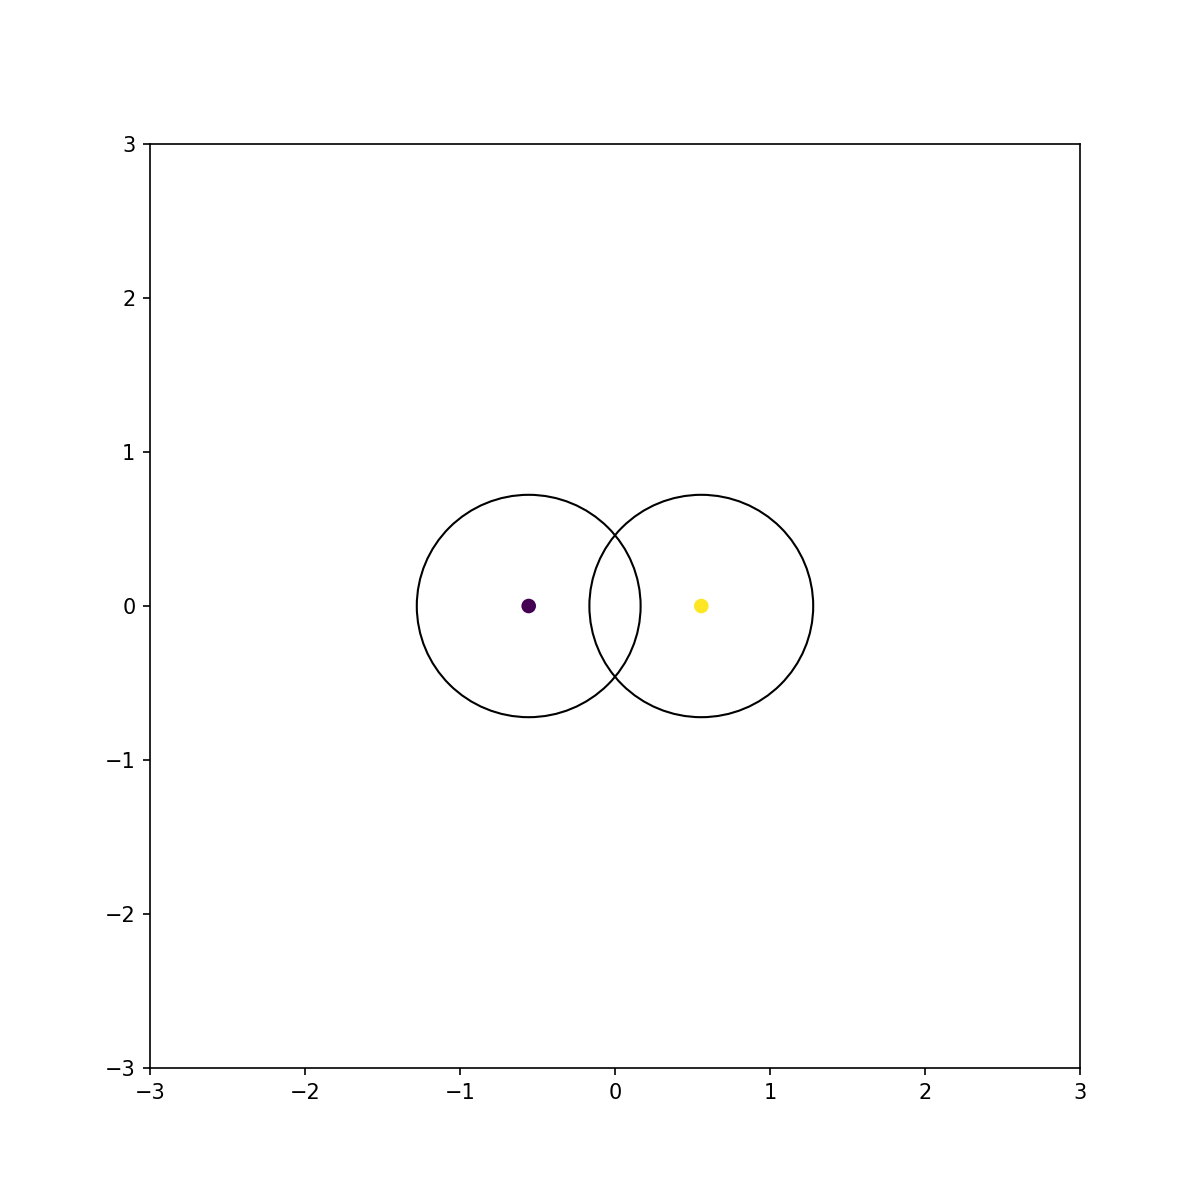

In [78]:
x_init = np.array([[-1., -1e-5], [1., 1e-5]])*2.9
positions, nsteps = descent_h_lj(x_init, 1e-3)
print('# of steps:', nsteps, '| positions.shape:', positions.shape)
print(positions[1])
print(positions[-1])

fig, ax = plt.subplots(figsize=(8, 8))
colors = np.arange(len(x_init))
scat = ax.scatter(x_init[:,0], x_init[:,1], c=colors)
circles = [plt.Circle(r, radius=0.722, fill=False) 
            for i,r in enumerate(x_init)]
for c in circles:
    plt.gca().add_patch(c)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
def animate(i):
    index = i
    data = positions[index]
    scat.set_offsets(data)
    for i, c in enumerate(circles):
        c.center = data[i]
    return scat

anim = animation.FuncAnimation(fig, animate, interval=1)

In [11]:
x_init = np.array([[-1., 0], [1.2, -0]])*2.9
positions, nsteps = descent_h_lj(x_init, 1e-3)
print('# of steps:', nsteps, '| positions.shape:', positions.shape)
print(positions[1])
print(positions[-1])

# of steps: 0 | positions.shape: (1, 2, 2)


IndexError: index 1 is out of bounds for axis 0 with size 1

In [65]:
import random

def Random_particles( N, dim=3 ):
    """Creates a list of N particles with random positions and charges
    
    Arguments:
        N (int): number of particles
        
    Output:
        x (float): position vectors (dim = N x 3)
        q (int): charges (dim = N)
    """
    return np.random.uniform(-1,1, size=(N,dim)), np.array([[-1, 1][random.randrange(2)] for i in range(N)])

In [161]:
N = 10
dim = 2
x, y = np.linspace(-N, N, N), np.linspace(-N, N, N)
XX, YY = np.meshgrid(x,y)
q = 10.*np.array([[-1,1][random.randrange(2)] for i in range(N*N)])
print(q)
x_init =np.array([XX.flatten(),YY.flatten()]).T+np.random.uniform(low=-0.5, high=0.5,size=(N*N,dim))
#x_init *= 10
print(len(x_init))
positions, nsteps = descent_h_lj_c(x_init,q, k=0., a=1e-4,prec=1e-5, maxst=20000)

[ 10. -10. -10. -10.  10. -10. -10. -10.  10. -10.  10.  10.  10.  10.
 -10.  10. -10.  10. -10. -10. -10.  10. -10. -10. -10.  10.  10. -10.
 -10. -10. -10. -10. -10. -10.  10.  10. -10. -10.  10. -10. -10.  10.
 -10.  10.  10.  10.  10. -10. -10. -10. -10.  10. -10. -10. -10. -10.
 -10.  10.  10. -10.  10. -10.  10.  10.  10. -10.  10. -10.  10. -10.
  10.  10.  10.  10. -10. -10. -10.  10. -10.  10.  10. -10. -10.  10.
 -10. -10. -10. -10.  10.  10.  10. -10.  10.  10.  10.  10.  10.  10.
  10. -10.]
100


# of steps: 20000 | positions.shape: (20001, 100, 2)
100
100


<IPython.core.display.Javascript object>


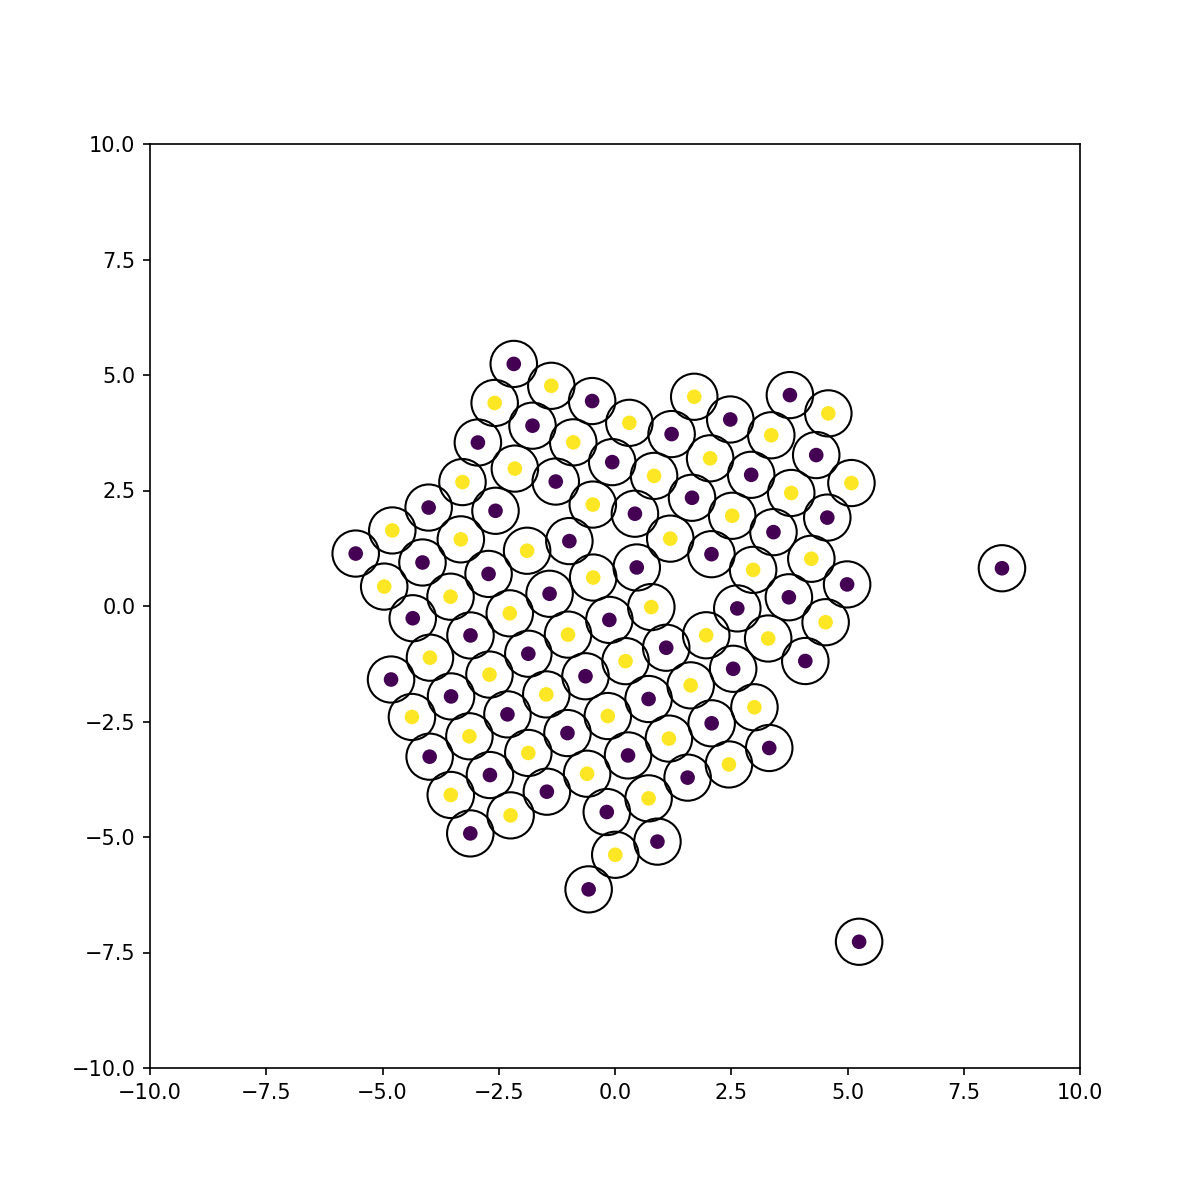

In [163]:
print('# of steps:', nsteps, '| positions.shape:', positions.shape)
print(len(x_init))
#print(positions[0])
#print(positions[-1])
mask=np.count_nonzero(np.linalg.norm(positions[-1], axis=-1)<10)
print(mask)
fig, ax = plt.subplots(figsize=(8, 8))
colors = np.arange(len(x_init))
scat = ax.scatter(x_init[:,0], x_init[:,1], c=q)
circles = [plt.Circle(r, radius=0.5, fill=False) 
            for i,r in enumerate(x_init)]

for c in circles:
    plt.gca().add_patch(c)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
def animate(i):
    index = 4*i
    data = positions[index]
    scat.set_offsets(data)
    for i, c in enumerate(circles):
        c.center = data[i]
    return scat

anim = animation.FuncAnimation(fig, animate, interval=1)

In [166]:
def grad_ljho:
    return

def grad_ljcho(x, q, boxsize=(0, 1)):
    vecs = vectors(x, boxsize)
    return gradients.harmonic(x, boxsize) + gradients.LJ(vecs) - gradients.coulomb(vecs, q)

def descent( x, q, grad, a=1e-4, prec=1e-10, maxst=1e6, k=.1, boxsize=(0, 1) ):
    """Gradient Descent
    
    Arguments:
        x    (float): position vectors (dim = n x 3)
        q: charge
        a    (float): 'learning rate' alpha = 1e-4
        prec (float): difference between steps, precision = 1e-10
        maxst  (int): max # of steps, maxst = 1e6
        k: factor harmonic pot
    
    Output:
        x: position array,
        step: # of steps needed to converge"""
    
    x = x[None, :, :]
    step = 0
    vecs = vectors(x[-1], boxsize)
    #f = gradients.harmonic(x[-1], boxsize) + gradients.LJ(vecs) - gradients.coulomb(vecs, q)
    f = grad(x[-1], q)
    x1 = x[-1] - a * f
    
    while step < maxst and np.linalg.norm(x[-1] - x1) > prec:
        x = np.append(x, x1[None, :, :], axis=0)
        vecs = vectors(x[-1], boxsize)
        #f = gradients.harmonic(x[-1], boxsize) + gradients.LJ(vecs) - gradients.coulomb(vecs, q)
        f = grad(x[-1], q)
        x1 = x[-1] - a * f
        step += 1
        
    return x, step

In [172]:
N = 7
dim = 2
x, y = np.linspace(-N, N, N), np.linspace(-N, N, N)
XX, YY = np.meshgrid(x,y)
q = 10.*np.array([[-1,1][random.randrange(2)] for i in range(N*N)])
print(q)
x_init =np.array([XX.flatten(),YY.flatten()]).T+np.random.uniform(low=-0.5, high=0.5,size=(N*N,dim))
#x_init *= 10
print(len(x_init))
positions, nsteps = descent(x_init, q, grad_ljcho, k=0., a=1e-4, prec=1e-5, maxst=20000)

[-7.         -4.66666667 -2.33333333  0.          2.33333333  4.66666667
  7.        ]
[ 10.  10. -10. -10. -10. -10.  10. -10. -10. -10. -10.  10.  10. -10.
  10.  10.  10.  10.  10.  10. -10.  10. -10.  10.  10.  10. -10.  10.
  10. -10. -10.  10. -10. -10. -10. -10. -10. -10.  10. -10.  10.  10.
  10. -10. -10. -10. -10.  10. -10.]
49


# of steps: 14172 | positions.shape: (14173, 49, 2)
49
49


<IPython.core.display.Javascript object>


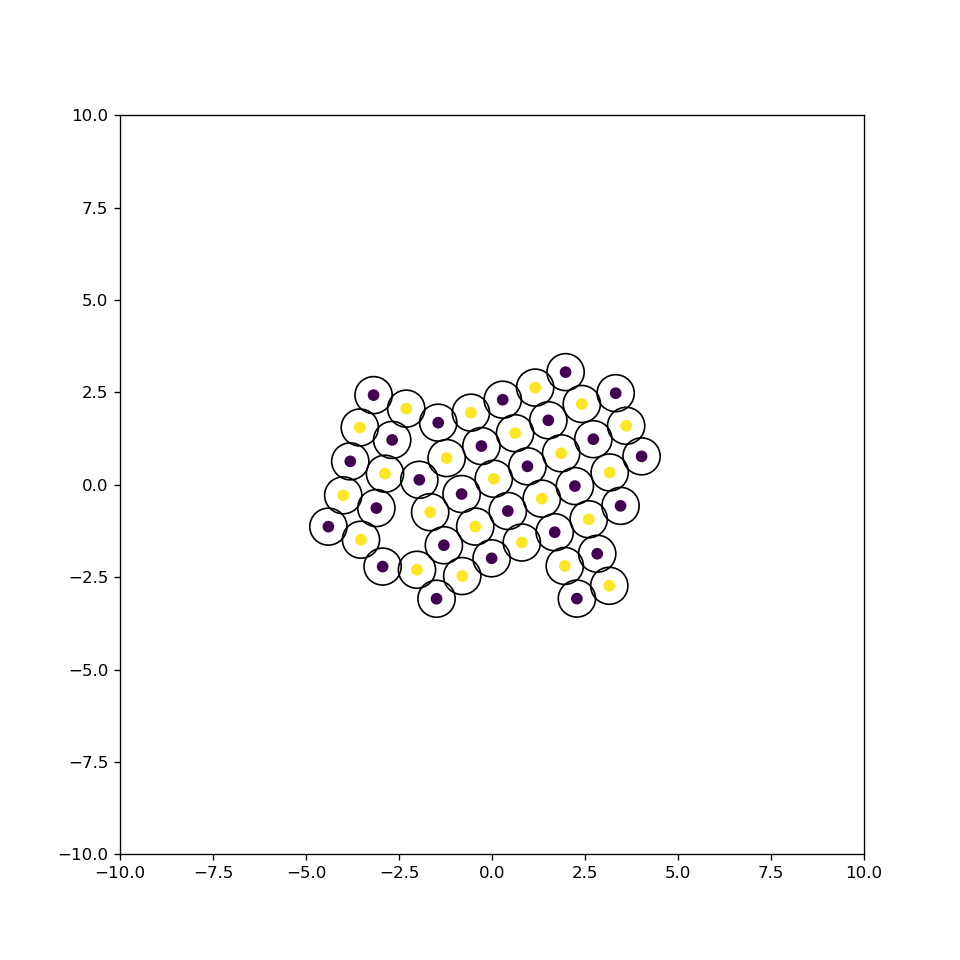

In [173]:
print('# of steps:', nsteps, '| positions.shape:', positions.shape)
print(len(x_init))
#print(positions[0])
#print(positions[-1])
mask=np.count_nonzero(np.linalg.norm(positions[-1], axis=-1)<10)
print(mask)
fig, ax = plt.subplots(figsize=(8, 8))
colors = np.arange(len(x_init))
scat = ax.scatter(x_init[:,0], x_init[:,1], c=q)
circles = [plt.Circle(r, radius=0.5, fill=False) 
            for i,r in enumerate(x_init)]

for c in circles:
    plt.gca().add_patch(c)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
def animate(i):
    index = 4*i
    data = positions[index]
    scat.set_offsets(data)
    for i, c in enumerate(circles):
        c.center = data[i]
    return scat

anim = animation.FuncAnimation(fig, animate, interval=1)